In [107]:
!pip install ucimlrepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from ucimlrepo import fetch_ucirepo

In [108]:
rice = fetch_ucirepo(id=545)

X = rice.data.features
y = rice.data.targets

print(f"Название целевой переменной: {list(y.columns)}")

Название целевой переменной: ['Class']


In [109]:
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

y_class = y_clean['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y_class)

num_classes = len(np.unique(y_encoded))

print(f"\nИтоговое распределение: {np.bincount(y_encoded)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")
print(f"Количество классов: {len(np.unique(y_encoded))}")


Итоговое распределение: [1630 2180]

Размер train выборки: (3048, 7)
Размер test выборки: (762, 7)
Количество классов: 2


In [110]:
def create_base_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

input_dim = X_train_scaled.shape[1]

base_model = create_base_model(input_dim)
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Архитектура базовой модели:")
base_model.summary()

Архитектура базовой модели:


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
history_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_base, test_accuracy_base = base_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nБазовая модель - Test Loss: {test_loss_base:.4f}")
print(f"Базовая модель - Test Accuracy: {test_accuracy_base:.4f}")

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5235 - loss: 0.6500 - val_accuracy: 0.9197 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8968 - loss: 0.3676 - val_accuracy: 0.9180 - val_loss: 0.2220 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9416 - loss: 0.2071 - val_accuracy: 0.9213 - val_loss: 0.2226 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9246 - loss: 0.2007 - val_accuracy: 0.9213 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9292 - loss: 0.2126 - val_accuracy: 0.9148 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.1977 - val_accuracy: 0.9180 - val_loss: 0.2275 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9366 - loss: 0.1823 - val_acc

In [112]:
print("\nОЦЕНКА F1-SCORE НА ТЕСТОВЫХ ДАННЫХ")

y_pred_proba = base_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

print(f"F1-Score (weighted): {f1:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score по классам:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name}: {f1_per_class[i]:.4f}")

print("\nДетальная классификация:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


ОЦЕНКА F1-SCORE НА ТЕСТОВЫХ ДАННЫХ
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-Score (weighted): 0.2564
F1-Score (macro): 0.2996
F1-Score по классам:
  Cammeo: 0.5993
  Osmancik: 0.0000

Детальная классификация:
              precision    recall  f1-score   support

      Cammeo       0.43      1.00      0.60       326
    Osmancik       0.00      0.00      0.00       436

    accuracy                           0.43       762
   macro avg       0.21      0.50      0.30       762
weighted avg       0.18      0.43      0.26       762



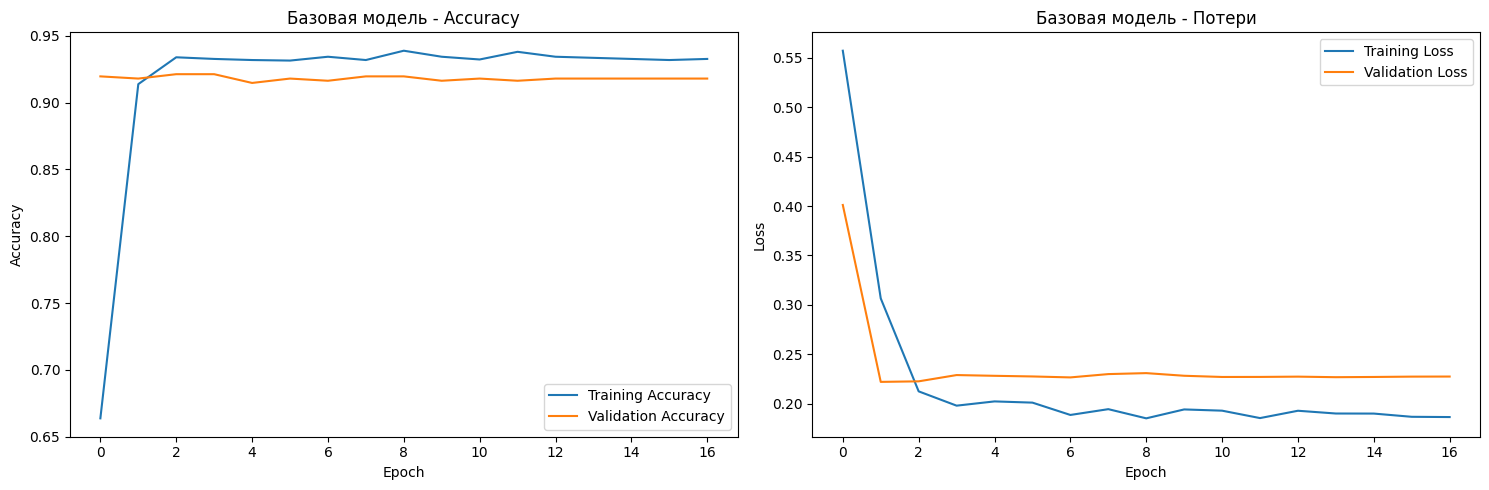

In [113]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Training Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Базовая модель - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Training Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Базовая модель - Потери')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [114]:
print("АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ")

pretrained_weights = []

print("1. Обучение первого автоэнкодера:")
input_data = X_train_scaled
input_dim = X_train_scaled.shape[1]

encoder1 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,), name='encoder1')
])

decoder1 = models.Sequential([
    layers.Dense(input_dim, activation='linear', name='decoder1')
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder1.compile(optimizer='adam', loss='mse')

history1 = autoencoder1.fit(
    input_data, input_data,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Первый автоэнкодер обучен. Final loss: {history1.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder1.layers[0].get_weights())

print("2. Обучение второго автоэнкодера:")
encoded_data1 = encoder1.predict(input_data, verbose=0)

encoder2 = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(64,), name='encoder2')
])

decoder2 = models.Sequential([
    layers.Dense(64, activation='linear', name='decoder2')
])

autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder2.compile(optimizer='adam', loss='mse')

history2 = autoencoder2.fit(
    encoded_data1, encoded_data1,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Второй автоэнкодер обучен. Final loss: {history2.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder2.layers[0].get_weights())

print("3. Обучение третьего автоэнкодера:")
encoded_data2 = encoder2.predict(encoded_data1, verbose=0)

encoder3 = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(32,), name='encoder3')
])

decoder3 = models.Sequential([
    layers.Dense(32, activation='linear', name='decoder3')
])

autoencoder3 = models.Sequential([encoder3, decoder3])
autoencoder3.compile(optimizer='adam', loss='mse')

history3 = autoencoder3.fit(
    encoded_data2, encoded_data2,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Третий автоэнкодер обучен. Final loss: {history3.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder3.layers[0].get_weights())

print("Все автоэнкодеры обучены!")

АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ
1. Обучение первого автоэнкодера:
  Первый автоэнкодер обучен. Final loss: 0.0001
2. Обучение второго автоэнкодера:
  Второй автоэнкодер обучен. Final loss: 0.0001
3. Обучение третьего автоэнкодера:
  Третий автоэнкодер обучен. Final loss: 0.0008
Все автоэнкодеры обучены!


In [115]:
print("СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ")

pretrained_model = models.Sequential()

pretrained_model.add(layers.Dense(64, activation='relu',
                                input_shape=(input_dim,),
                                name='pretrained_layer1'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(32, activation='relu',
                                name='pretrained_layer2'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(16, activation='relu',
                                name='pretrained_layer3'))
pretrained_model.add(layers.Dropout(0.2))

pretrained_model.add(layers.Dense(num_classes, activation='softmax',
                                name='output_layer'))

pretrained_model.layers[0].set_weights(pretrained_weights[0])
pretrained_model.layers[2].set_weights(pretrained_weights[1])
pretrained_model.layers[4].set_weights(pretrained_weights[2])

pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура модели с предобучением:")
pretrained_model.summary()

СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ
Архитектура модели с предобучением:


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_layer1 (Dense)       │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer2 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer3 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,154 (12.32 KB)

 Trainable params: 3,154 (12.32 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
print("ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА")

history_pretrained = pretrained_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_pretrained, test_accuracy_pretrained = pretrained_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nМодель с предобучением - Test Loss: {test_loss_pretrained:.4f}")
print(f"Модель с предобучением - Test Accuracy: {test_accuracy_pretrained:.4f}")

ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7919 - loss: 0.4320 - val_accuracy: 0.9148 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9093 - loss: 0.2215 - val_accuracy: 0.9148 - val_loss: 0.2303 - learning_rate: 0.0010
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9140 - loss: 0.2139 - val_accuracy: 0.9180 - val_loss: 0.2382 - learning_rate: 0.0010
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9299 - loss: 0.2224 - val_accuracy: 0.9164 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9164 - loss: 0.2178 - val_accuracy: 0.9164 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9225 - loss: 0.2237 - val_accuracy: 0.9180 - val_loss: 0.2349 - learning_rate: 0.0010
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - ac

In [117]:
print("\nОЦЕНКА F1-SCORE НА ТЕСТОВЫХ ДАННЫХ")

y_pred_proba = pretrained_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

f1 = f1_score(y_test, y_pred_classes, average='weighted')
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

print(f"F1-Score (weighted): {f1:.4f}")
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"F1-Score по классам:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name}: {f1_per_class[i]:.4f}")

print("\nДетальная классификация:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


ОЦЕНКА F1-SCORE НА ТЕСТОВЫХ ДАННЫХ
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-Score (weighted): 0.9067
F1-Score (macro): 0.9047
F1-Score по классам:
  Cammeo: 0.8903
  Osmancik: 0.9190

Детальная классификация:
              precision    recall  f1-score   support

      Cammeo       0.90      0.88      0.89       326
    Osmancik       0.91      0.92      0.92       436

    accuracy                           0.91       762
   macro avg       0.91      0.90      0.90       762
weighted avg       0.91      0.91      0.91       762



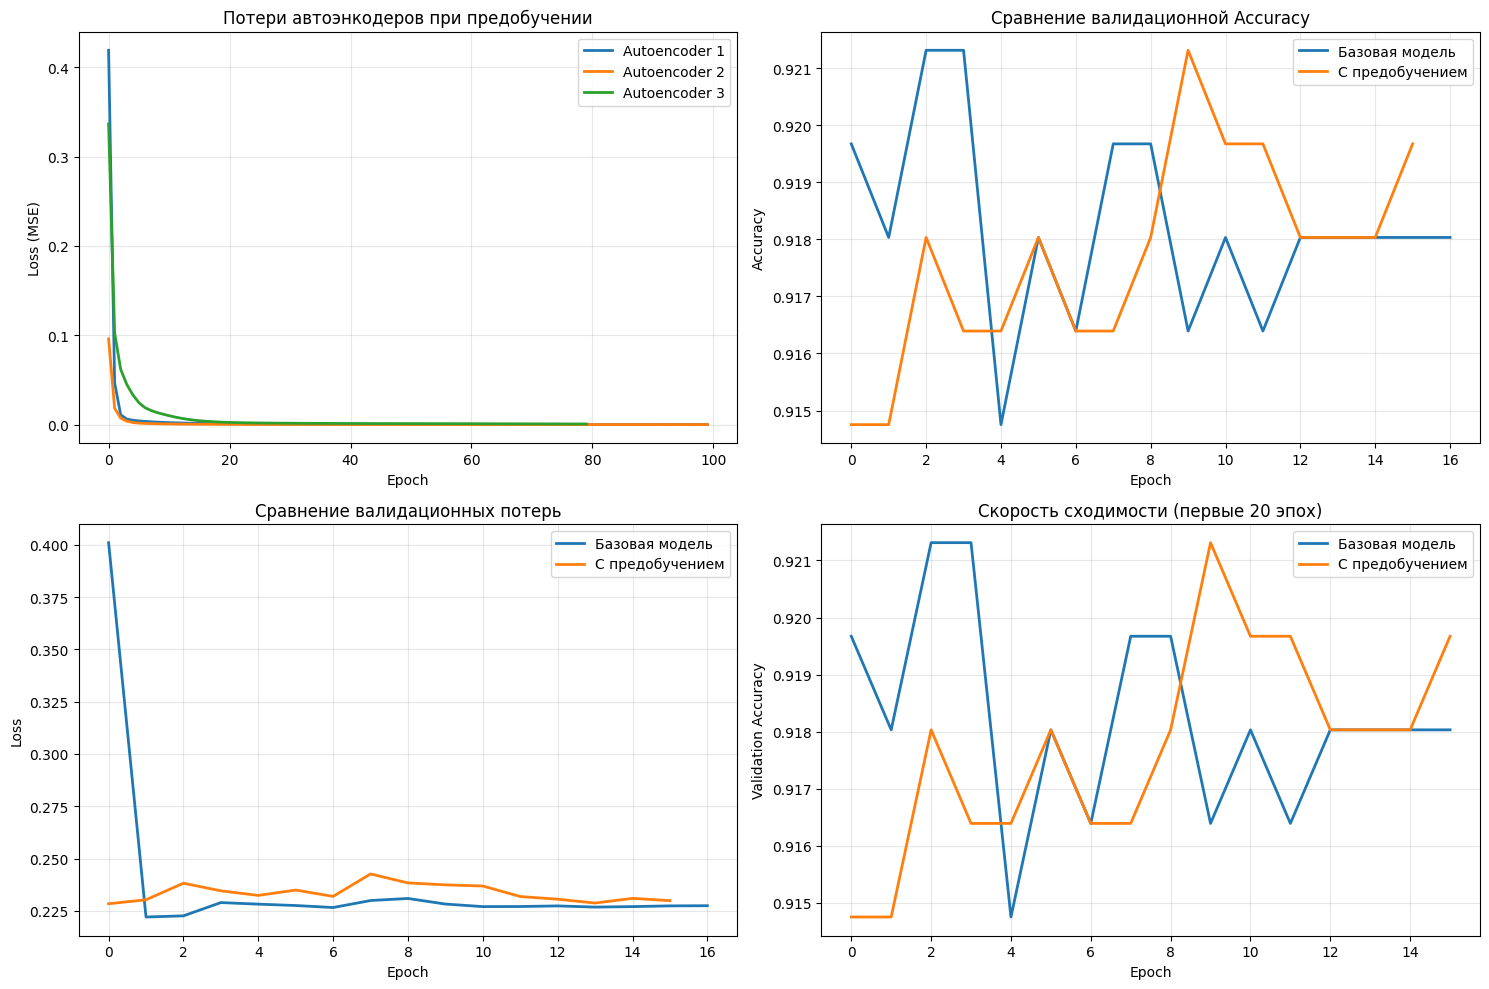

In [118]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Autoencoder 1', linewidth=2)
plt.plot(history2.history['loss'], label='Autoencoder 2', linewidth=2)
plt.plot(history3.history['loss'], label='Autoencoder 3', linewidth=2)
plt.title('Потери автоэнкодеров при предобучении')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history_base.history['val_accuracy'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_accuracy'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационной Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(history_base.history['val_loss'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_loss'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационных потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
min_epochs = min(len(history_base.history['val_accuracy']),
                 len(history_pretrained.history['val_accuracy']), 20)
plt.plot(range(min_epochs), history_base.history['val_accuracy'][:min_epochs],
         label='Базовая модель', linewidth=2)
plt.plot(range(min_epochs), history_pretrained.history['val_accuracy'][:min_epochs],
         label='С предобучением', linewidth=2)
plt.title('Скорость сходимости (первые 20 эпох)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()